In [ ]:
import pandas as pd
import numpy as np
import matplotlib


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, GRU, concatenate
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("kddcup99_csv.csv")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [5]:
df.shape

(494020, 42)

In [4]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             494020 non-null  int64  
 13 

In [ ]:
print(df.describe(include="all")) 


       Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)
count      5.000000       5.000000    5.000000      5.000000
mean      94.200000      93.600000   94.200000     94.200000
std        3.420526       3.209361    3.114482      3.114482
min       90.000000      91.000000   91.000000     91.000000
25%       92.000000      92.000000   92.000000     92.000000
50%       95.000000      92.000000   94.000000     94.000000
75%       95.000000      94.000000   95.000000     95.000000
max       99.000000      99.000000   99.000000     99.000000


Class distribution in 'label':
label
smurf              280790
neptune            107201
normal              97277
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: count, dtype: int64


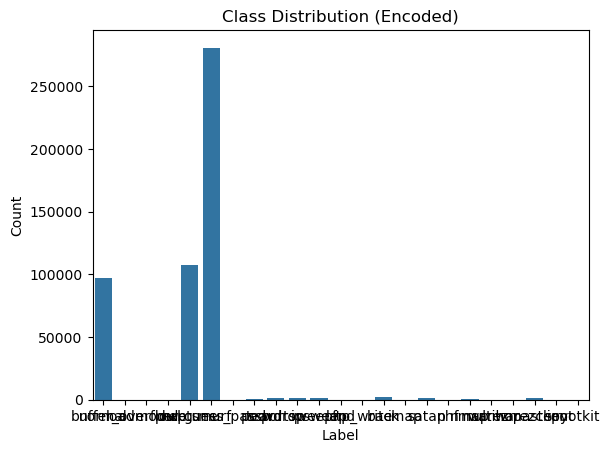

In [11]:
print("Class distribution in 'label':")
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.title("Class Distribution (Encoded)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

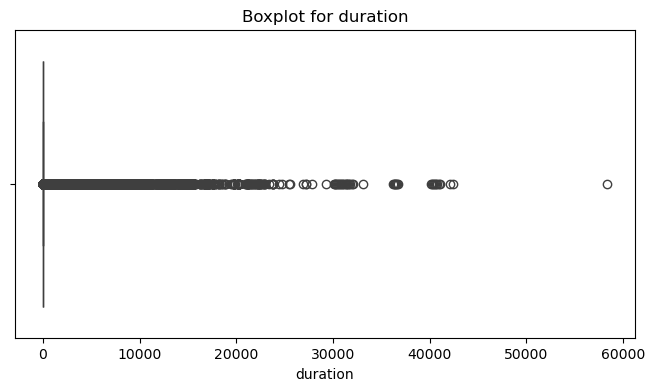

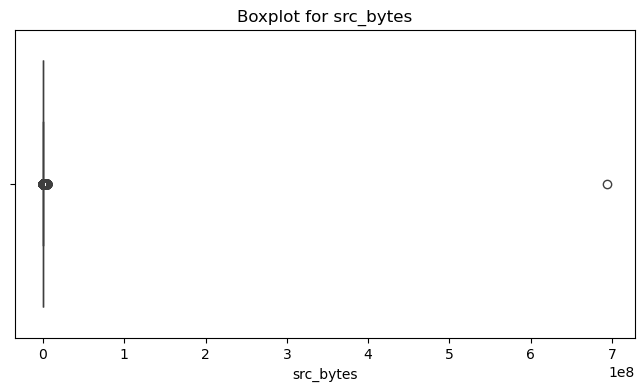

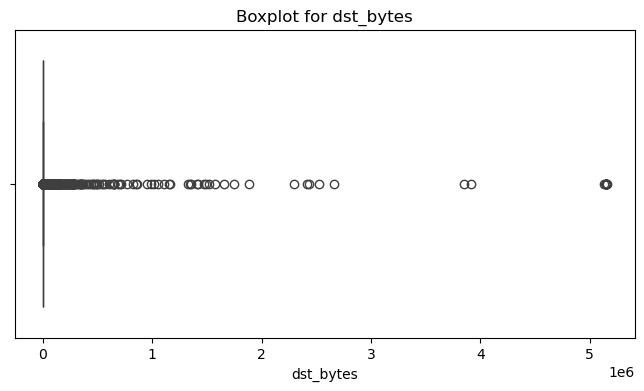

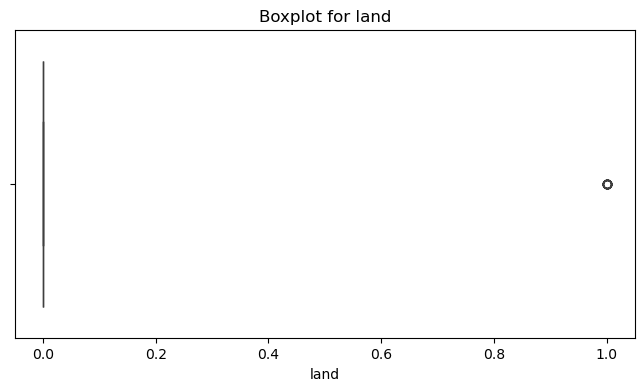

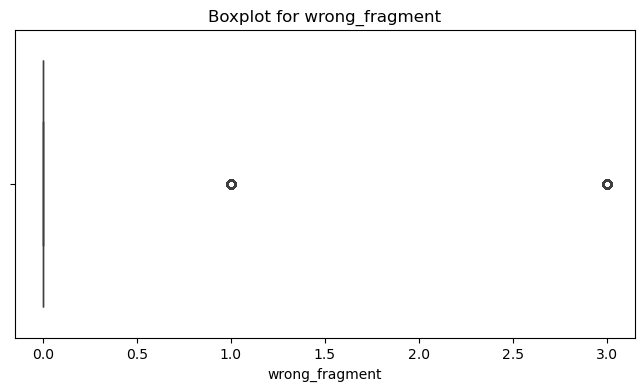

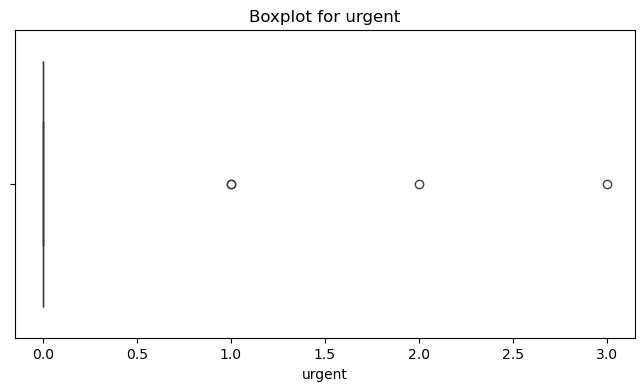

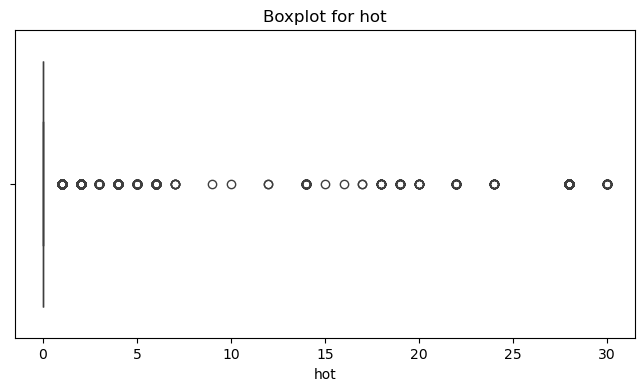

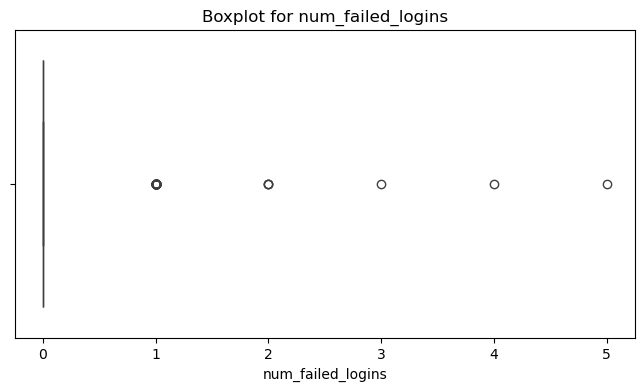

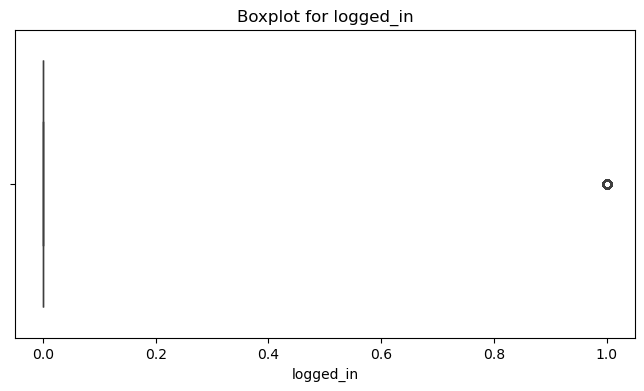

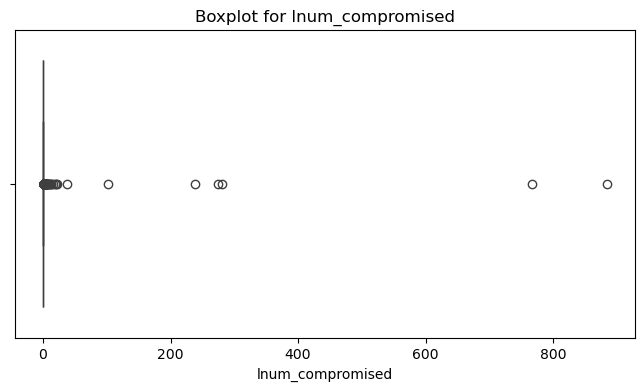

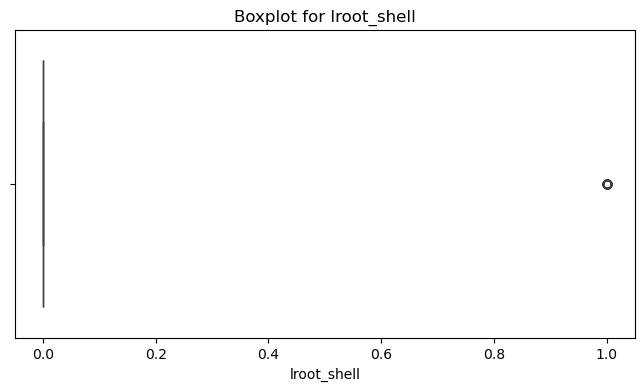

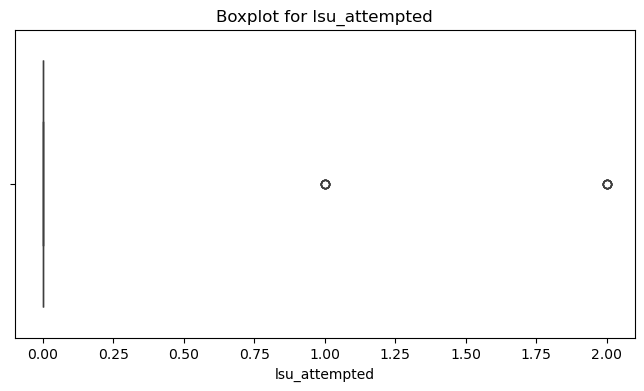

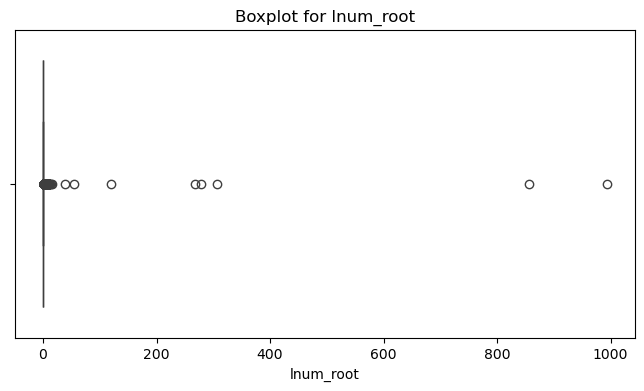

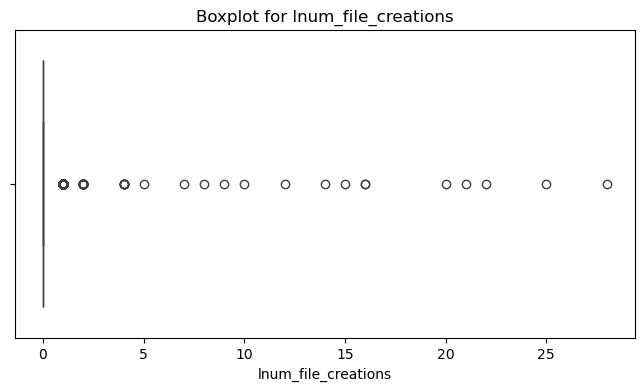

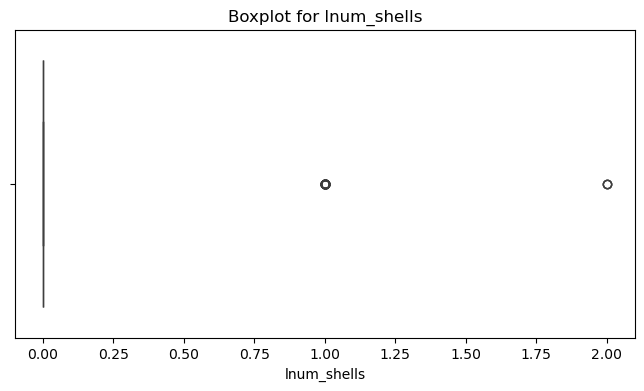

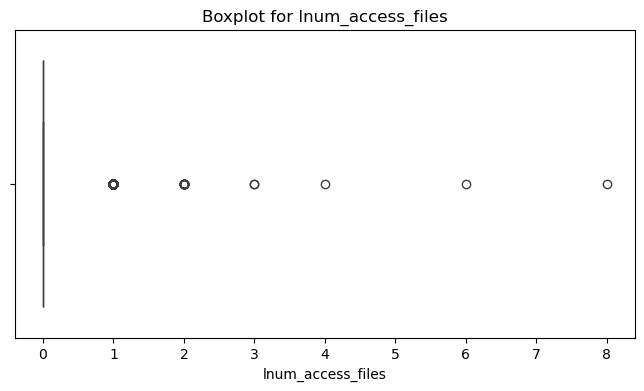

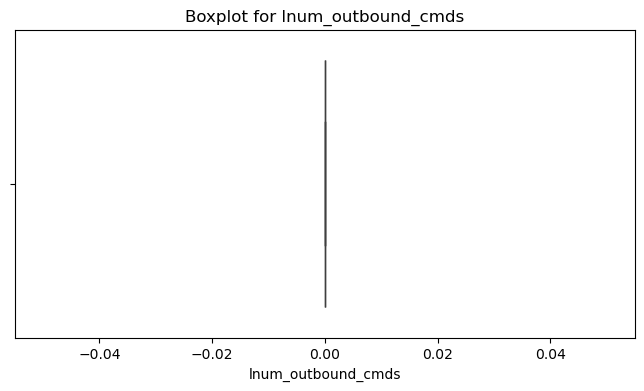

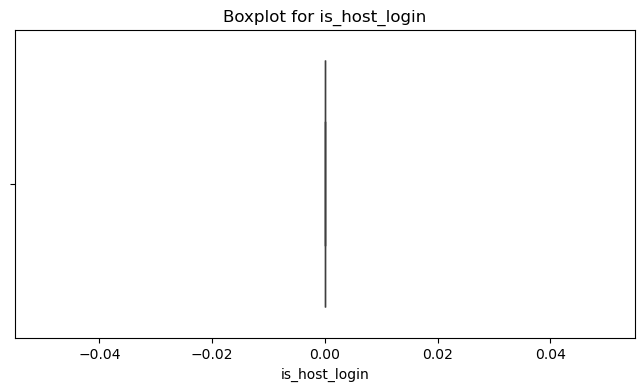

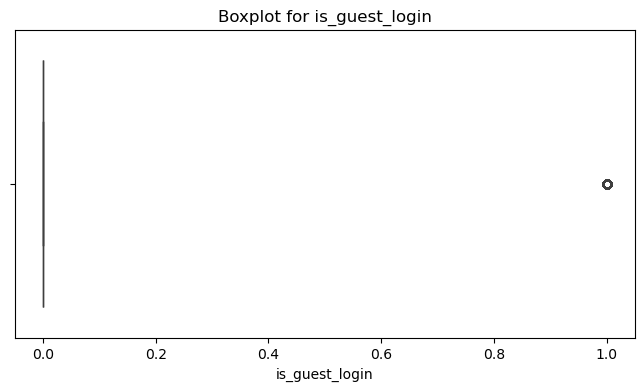

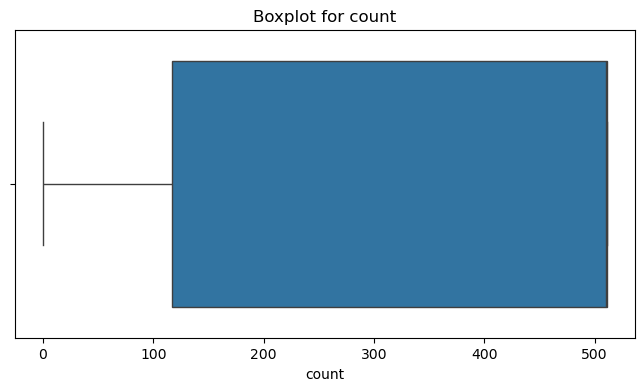

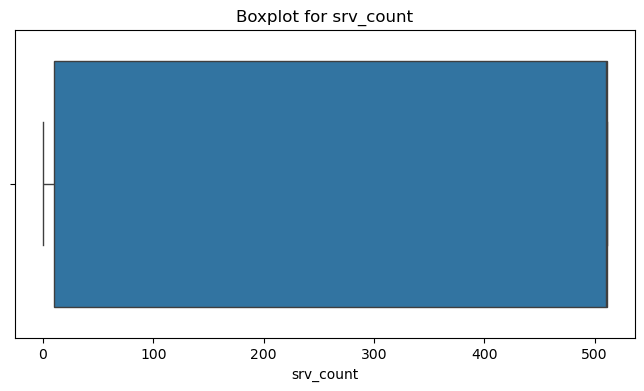

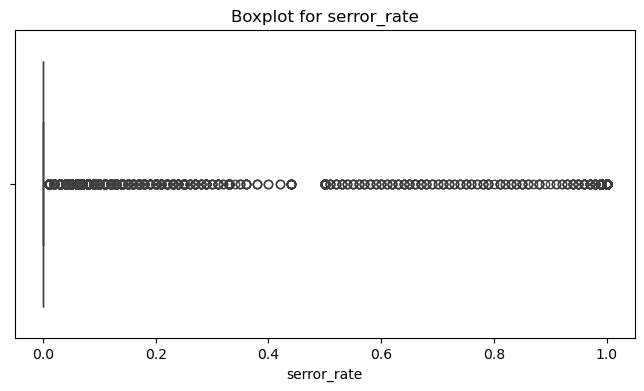

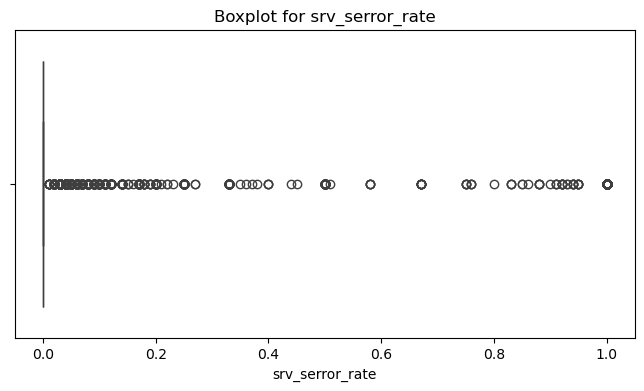

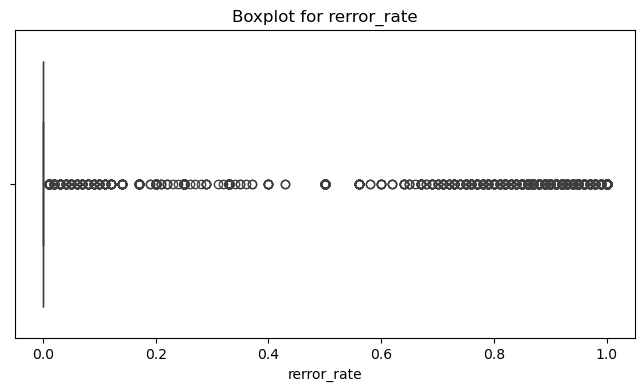

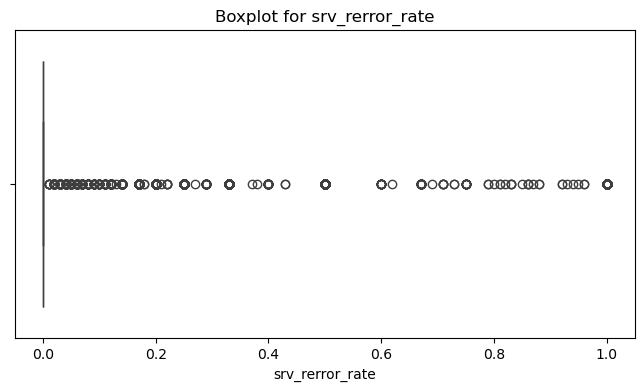

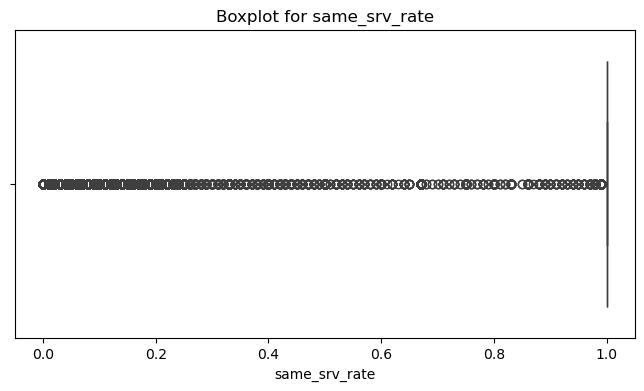

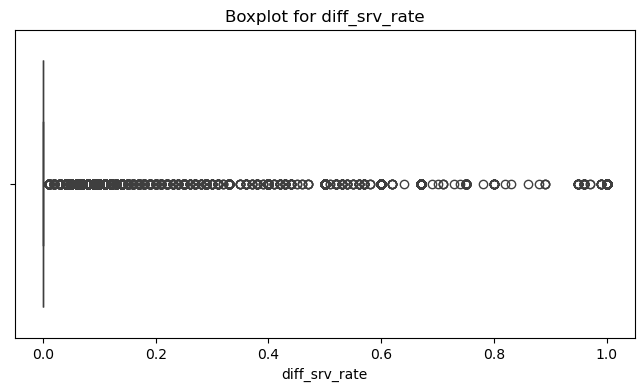

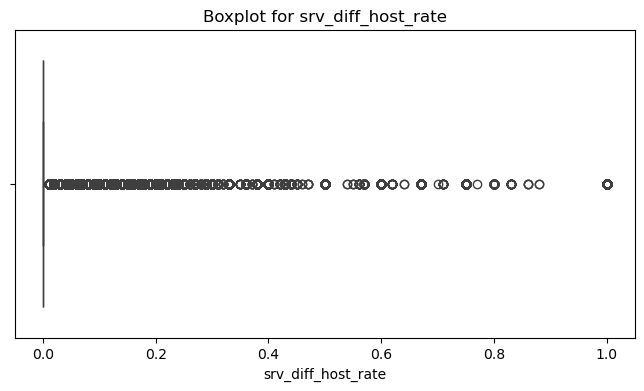

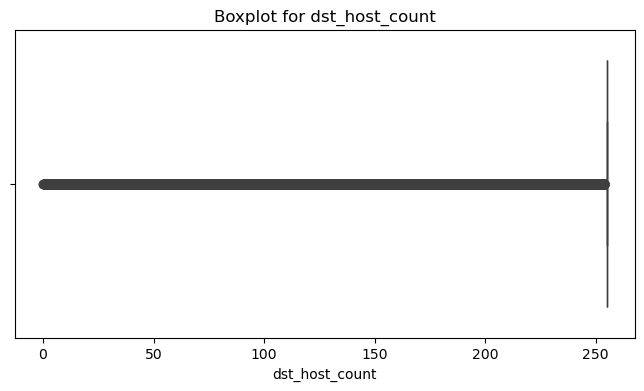

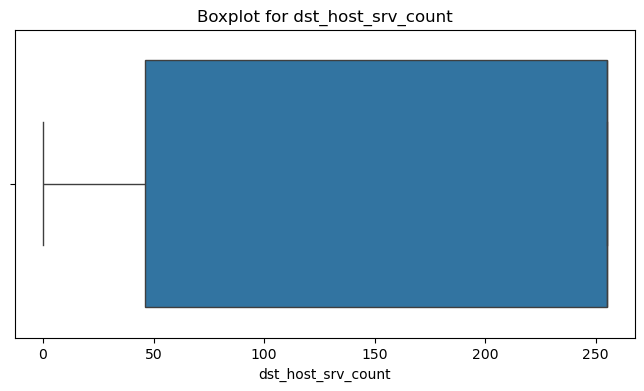

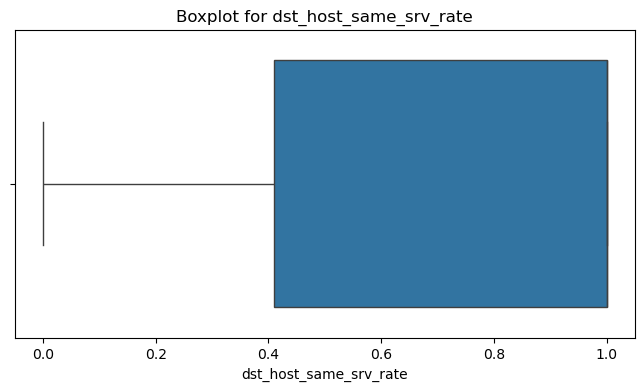

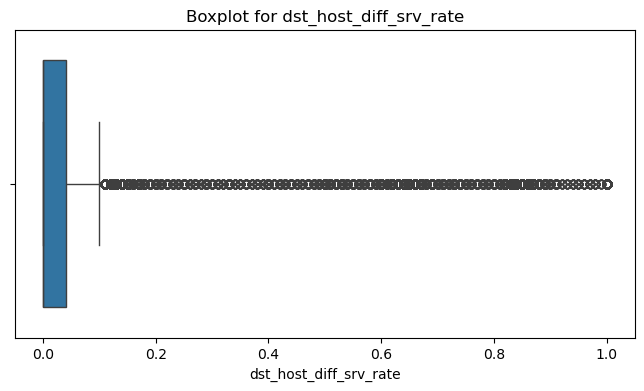

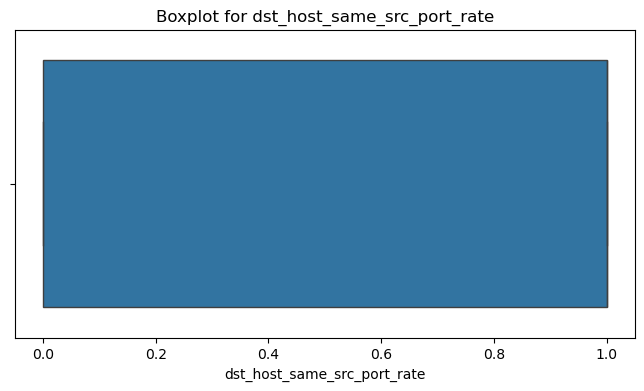

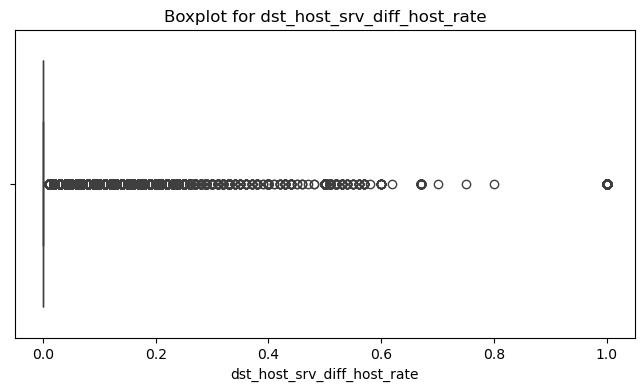

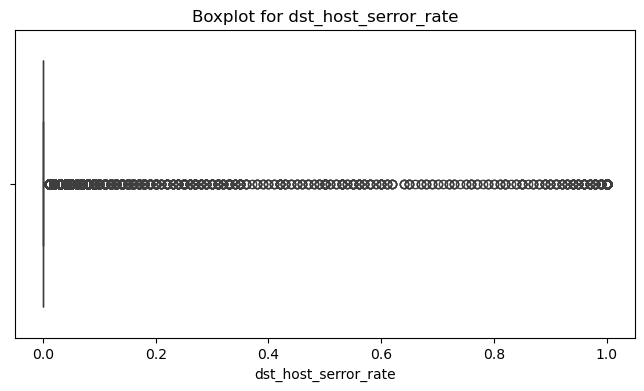

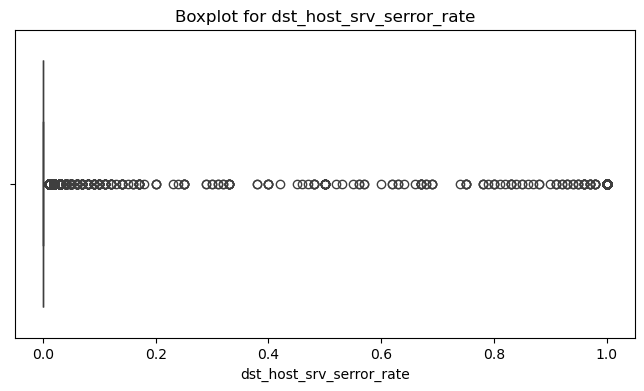

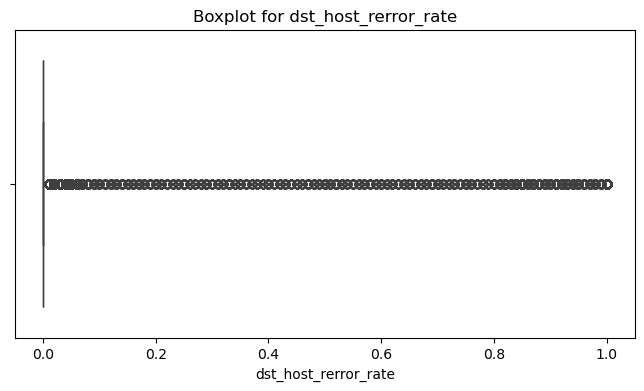

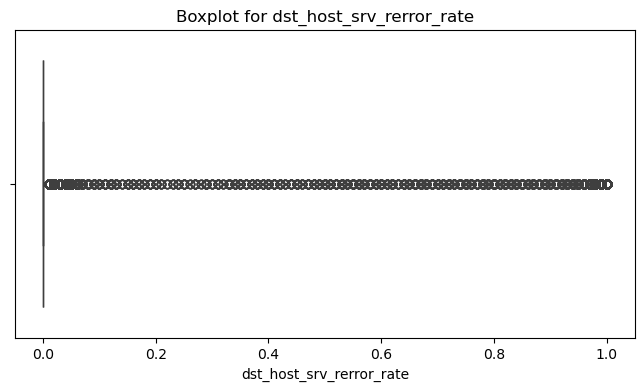

In [15]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot for {col}")
    plt.show()

In [6]:
input_cols = list(df.columns)[1:-1]
target_col = 'label'
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()[:-1]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

target = df['label']
df['label'] = le.fit_transform(target)
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(train_df.shape)
print(test_df.shape)

(345814, 42)
(148206, 42)


In [10]:
X = df.drop(columns=['label'])
y = df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))
cnn_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
cnn_output = Flatten()(cnn_layer)

gru_output = GRU(32, return_sequences=False)(input_layer)
combined_features = concatenate([cnn_output, gru_output])

In [13]:
feature_extraction_model = Model(inputs=input_layer, outputs=combined_features)


In [14]:
train_features = feature_extraction_model.predict(X_train_reshaped)
test_features = feature_extraction_model.predict(X_test_reshaped)

12351/12351 ━━━━━━━━━━━━━━━━━━━━ 129s 10ms/step
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step


In [15]:
catboost_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,  verbose=10)
catboost_model.fit(train_features, y_train)
from tensorflow.keras.models import load_model
import joblib


feature_extraction_model.save("cnn_gru_feature_extractor.h5")
catboost_model.save_model("catboost_classifier.cbm")




0:	learn: 1.1947747	total: 1m 18s	remaining: 2h 9m 14s
10:	learn: 0.2953293	total: 14m 22s	remaining: 1h 56m 22s
20:	learn: 0.1033663	total: 24m 55s	remaining: 1h 33m 45s
30:	learn: 0.0404213	total: 31m 50s	remaining: 1h 10m 52s
40:	learn: 0.0173812	total: 1h 11m 39s	remaining: 1h 43m 6s
50:	learn: 0.0089668	total: 1h 18m 47s	remaining: 1h 15m 41s
60:	learn: 0.0057196	total: 1h 25m 53s	remaining: 54m 55s
70:	learn: 0.0043235	total: 1h 33m 1s	remaining: 37m 59s
80:	learn: 0.0036252	total: 1h 41m 14s	remaining: 23m 44s
90:	learn: 0.0032156	total: 1h 48m 27s	remaining: 10m 43s
99:	learn: 0.0029036	total: 1h 55m 8s	remaining: 0us


In [ ]:
from ddos_graph import DDOSGraphGeneration
loaded_feature_extraction_model = load_model("cnn_gru_feature_extractor.h5")
loaded_catboost_model = CatBoostClassifier()
loaded_catboost_model.load_model("catboost_classifier.cbm")

In [34]:
y_pred = catboost_model.predict(test_features)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       431
           1       0.62      0.45      0.53        11
           2       0.00      0.00      0.00         1
           3       1.00      0.88      0.93         8
           4       1.00      0.67      0.80         3
           5       1.00      0.99      0.99       263
           6       1.00      0.67      0.80         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     21408
          10       1.00      0.96      0.98        45
          11       1.00      1.00      1.00     19366
          12       0.00      0.00      0.00         1
          14       1.00      0.93      0.96        41
          15       1.00      0.97      0.98       221
          16       0.00      0.00      0.00         1
          17       1.00      0.96      0.98       305
    

D:\anaconda_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


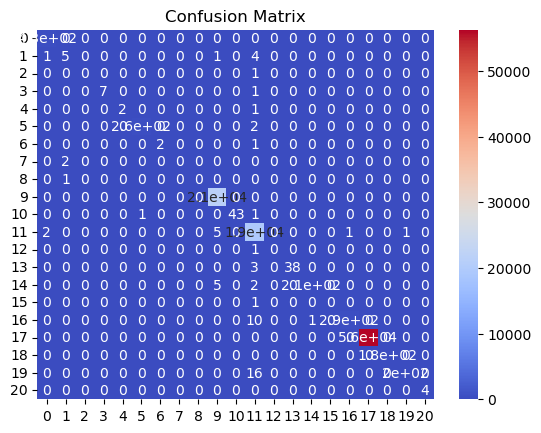

In [36]:

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm')
plt.title("Confusion Matrix")
plt.show()

Epoch 1/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 257s 20ms/step - loss: 8.4653e-04 - val_loss: 2.5373e-11
Epoch 2/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 276s 22ms/step - loss: 3.0932e-10 - val_loss: 7.9557e-11
Epoch 3/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 256s 21ms/step - loss: 3.2959e-10 - val_loss: 8.3950e-10
Epoch 4/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 241s 19ms/step - loss: 2.6310e-10 - val_loss: 1.1807e-11
Epoch 5/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 255s 21ms/step - loss: 1.8240e-10 - val_loss: 1.3348e-11
Epoch 6/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 262s 21ms/step - loss: 1.8370e-10 - val_loss: 7.3953e-12
Epoch 7/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 312s 25ms/step - loss: 2.5135e-10 - val_loss: 3.4934e-10
Epoch 8/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 281s 23ms/step - loss: 1.4787e-10 - val_loss: 9.2613e-11
Epoch 9/10
12351/12351 ━━━━━━━━━━━━━━━━━━━━ 263s 21ms/step - loss: 1.8861e-10 - val_loss: 2.2119e-11


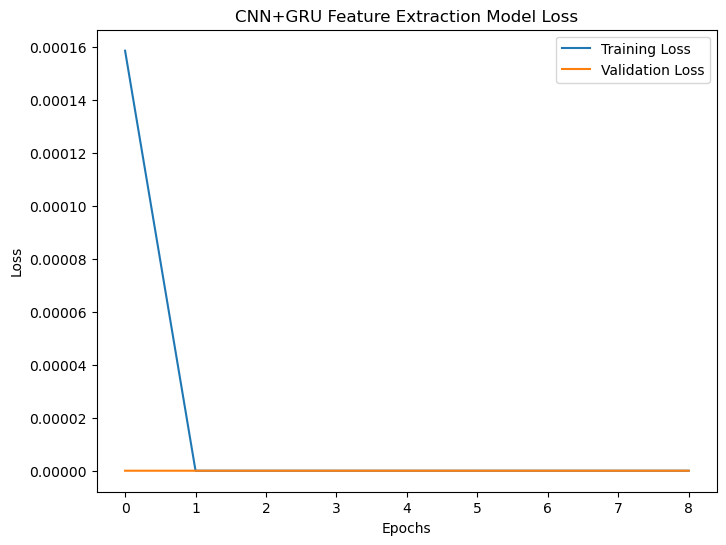

In [44]:
feature_extraction_model.compile(optimizer='adam', loss='mse')
history = feature_extraction_model.fit(
    X_train_reshaped,
    np.zeros((X_train_reshaped.shape[0], combined_features.shape[1])),
    validation_data=(X_test_reshaped, np.zeros((X_test_reshaped.shape[0], combined_features.shape[1]))),
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN+GRU Feature Extraction Model Loss")
plt.legend()
plt.show()


<Figure size 1000x600 with 0 Axes>

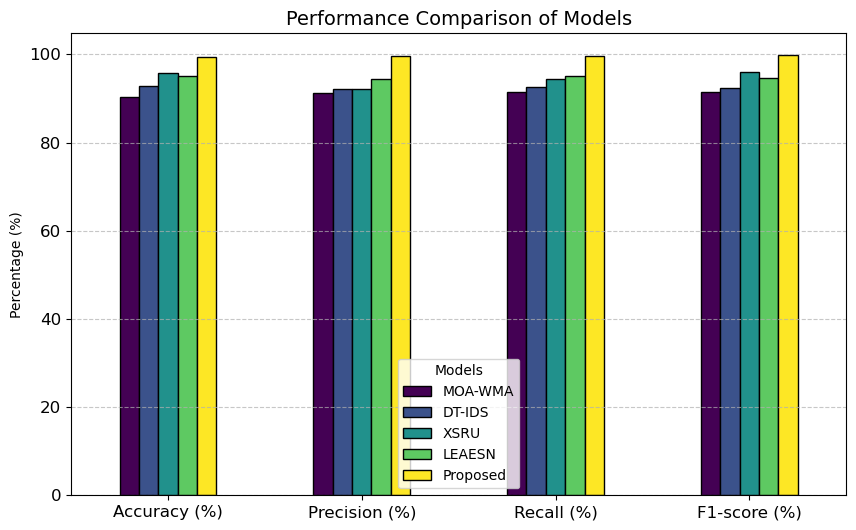

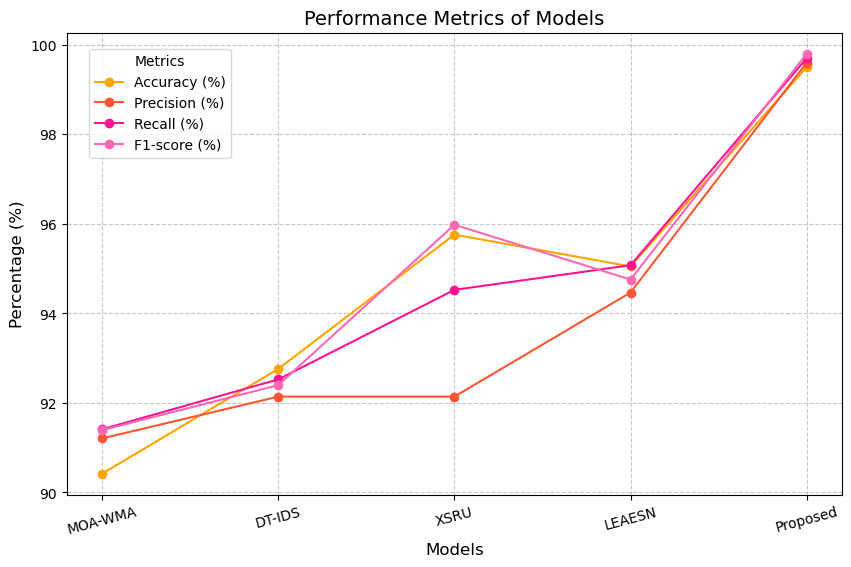

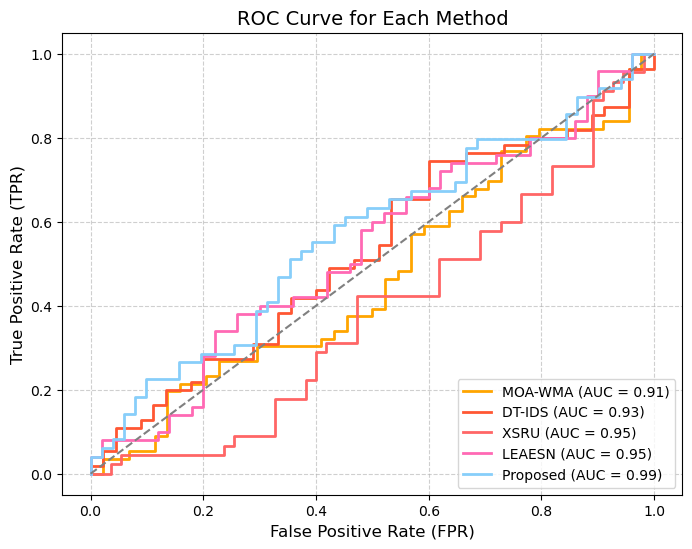

In [ ]:

graph_generator = DDOSGraphGeneration()
graph_generator.plot_bar_chart()
graph_generator.plot_line_chart()
graph_generator.plot_roc_curve()
